In [200]:
from IPython.paths import locate_profile
from notebook.services.config.manager import ConfigManager
cm = ConfigManager()

cm.update('livereveal', {
          'theme': 'white',
          'transition': 'linear',
          'start_slideshow_at': 'selected',
          'width': 1024,
          'height': 768
})

{'controls': False,
 'height': 768,
 'start_slideshow_at': 'selected',
 'theme': 'white',
 'transition': 'linear',
 'width': 1024}

In [243]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import matplotlib.cm as cm

from pylab import rcParams

import logging
logging.getLogger("gensim").setLevel(logging.ERROR)
logger = logging.getLogger()

import pickle
import datetime
import logging
import time
import pandas as pd
import numpy as np
from random import shuffle
import multiprocessing
import string
import itertools

import keras

import qgrid

import sklearn
from sklearn import feature_extraction
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import grid_search
from sklearn import pipeline
from sklearn import metrics
from sklearn import dummy
from sklearn import decomposition
from sklearn import manifold

import gensim
from gensim import models

import seaborn
import seaborn as sns
import statsmodels
sns.reset_defaults()
sns.set(color_codes=True)

In [244]:
# Default feature vector dimensionality
FEAT_DIM = 300

# Test set size
TEST_SIZE = 0.3

# checks for doc2vec
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

In [245]:
def plot_confusion_matrix(cm, data_Y_labels, 
                          title='Confusion Matrix', normalized=False,
                          cmap="Blues", filename=None, yticks=True,
                          colorbar=True):    
    if normalized:
        confusion_matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        confusion_matrix = cm
        
    with sns.axes_style("dark"):        
        
        fig = plt.figure()
        fig.set_figheight(3, forward=False)
        plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
        plt.title(title)
        if colorbar:
            plt.colorbar()
        tick_marks = np.arange(len(data_Y_labels))
        plt.xticks(tick_marks, data_Y_labels, rotation=90)
        plt.xlabel('Predicted label')
        if yticks:
            plt.yticks(tick_marks, data_Y_labels)
            plt.ylabel('True label')
        else:
            plt.yticks(tick_marks, [""]*len(data_Y_labels))
        
#         plt.tight_layout()        

        if filename != None:
            plt.savefig("plots/" + filename +".pdf", format='pdf', 
                    bbox_inches='tight')        
        plt.show()

In [246]:
df = pd.read_csv("/Users/cwestrup/thesis/data/collected/crowdflower/data/sentences_aggregated_50-449.csv")

In [247]:
# Use entries with label confidence over 0.6 and aren't test questions:
df_conf = df[df['0_label:confidence'] > 0.6]
df_conf = df_conf[df_conf['_golden'] == False]
df_conf = df_conf[['0_label', '0_label:confidence', '0-sentence',
         '0-context-after', '0-context-before']]

# data
data_X = np.array(df_conf['0-sentence'])
data_Y = np.array(df_conf['0_label'])

# train / validation split 
(X_train, X_test, Y_train, Y_test) = sklearn.cross_validation.train_test_split(
     data_X, data_Y, test_size=TEST_SIZE, random_state=0)

# labels in categorical encoding
le = sklearn.preprocessing.LabelEncoder()
le.fit(data_Y)
Y_categorical_labels = le.classes_
Y_categorical = le.transform(data_Y)
Y_categorical_train = le.transform(Y_train)
Y_categorical_test = le.transform(Y_test)

# encode categorically encoded labels in one-hot encoding
lb = sklearn.preprocessing.LabelBinarizer()
lb.fit(Y_categorical)
Y_onehot_labels = lb.classes_
Y_onehot = lb.transform(Y_categorical)
Y_onehot_train = lb.transform(Y_categorical_train)
Y_onehot_test = lb.transform(Y_categorical_test)

#  Representation Learning and Deep Sequential Modeling for Predicting Topics of Sentences in Job Advertisements

Clemens Westrup

Or a bit more understandable:

#  Text Classification on Sentences from Job Ads

## About me

- Clemens Westrup

- Master's in Machine Learning and Data Mining at Aalto University

- Now working as Data Scientist in Sanoma

- mail@clemenswestrup.de
- github.com/cle-ment

## About this talk 

- Based on Master's thesis (Can be found online: http://github.com/cle-ment/ma-thesis-tex)

- A project in collaboration with Sanoma 

- Problem domain: Job Advertisements (Oikotie Työpaikat)

- Topic: Text classification 

## Brief Outline

- Exploration of problem domain

- Formal Problem Definition

- Methods for Text Classification

- Results

- Conclusions

## A Typical Job Advertisement

<h4>(Senior) Research Scientist – MEMS designer VTT Technical Research Centre of Finland Ltd</h4>

<small>
You are a passionate researcher with proven experience in the field of MEMS and microelectronic components. With us, you will be responsible to set-up technological solutions, concepts and demonstrators for external and internal customers, starting from the sensor chip. You will be a member of the MEMS team. You will design, simulate, draw lithography masks and test MEMS components. You will have an impact on our customers’ innovation and valorise our sensing technologies with demonstrators as well as have a role in project preparation and possibly also project management. 
 
__We expect you to have__

A university degree in physics or applied physics.
Experience in MEMS design, analytical and numerical simulation (Ansys, Comsol or Simulink).
Knowledge on MEMS manufacturing processes.
Experience in MEMS read-out electronics and use of measurement equipment and software (e.g. LabView).
Programming skills, capable of using different software tools in synergy.
You speak English fluently.
The following experiences will be an asset: experience with customers, project management and creation of jointly funded project in Finland. 
 
As a person you are 
Active learner and team worker, you are eager to achieve things. You are efficient, well-organised and pro-active and you can work on a few projects in parallel. 
 
__We offer__ 

We offer you a working environment where we develop globally unique technologies and where you will have always renewed challenges and opportunities of achievement and technological fun. 
The position is in Espoo, Finland, where you are willing to relocate. You will be in the Sensors and integration research area and you will have the occasion to interact in-house with other disciplines, from silicon to cloud and more. 
 
For further information, please contact Anu Kärkkäinen, Research Team Leader, +358 40 820 5883, anu.karkkainen@vtt.fi
</small>

## Idea: Structure Content of Job Ads

- Could produce interesting insights / statistics about job ads


- Makes the data more usable for other purposes, e.g.:
    - Seperate requirements and further process them
    - What makes a good job ad? How does the structure affect popularity / success?

## Experiment: How would people structure job ads?

- Built minimal web service to collect paragraph labels (Node + MongoDB + Mustache)

- Collected: 91 tagged job ads = 379 tagged paragraphs and 358 tags

<img src="images/job-listing-structure.pdf" width="100%"/>

## Problem Definition: Multi-class Sentence Classification

- Set of labels $\mathcal{L} = \{ \text{benefits}, \text{candidate}, \text{company}, \text{job}, \text{nextsteps}, \text{other} \}$

- Set of Sentences $\mathcal{S}$

- Predict the label $l_i$ for a sentence $s_i$

- using a model function $\widetilde{\Phi} : \mathcal{S} \rightarrow \mathcal{L}$

## Dataset of Sentences

- Data extracted from API with package __requests__ 
- Converted from HTML into raw text using __beautifulsoup__ and split into sentences

- Labels collected using CrowdFlower.com

- In total: 10670 labelled english sentences
- 9948 with agreement of over 60%
- = 121,119 words and 807,984 characters

<img src="images/sentence-data-label-dist.pdf" width="100%"/>

Using __seaborn__ and __matplotlib__ we can visualize the distribution of the labels:

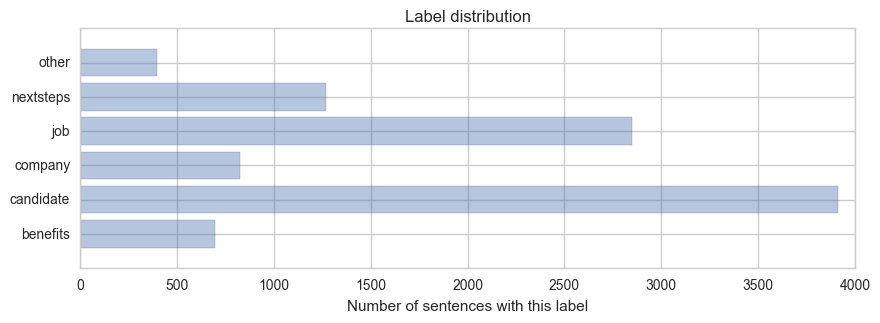

In [248]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10,3))
    labels = Y_categorical_labels
    y_pos = np.arange(len(labels))
    label_amounts = sum(Y_onehot)
    
    plt.barh(y_pos, label_amounts, align='center', alpha=0.4)
    plt.yticks(y_pos, labels)
    plt.xlabel('Number of sentences with this label')
    plt.title('Label distribution')
    plt.show()

Label | Description | Example Sentence
------|-------------|-----------------
benefits | Benefits: Rewards, opportunities, reasons to apply, ... | And we like to think we’ll give you an enjoyable and inspiring place to spend your working day. 
candidate | Candidate requirements: Requirements, skills, experience, education, personality, ... | To succeed in this position it is essential to have strong experience of at least 5 years in international business development and/or international B2B sales and marketing. 
company | Company information: Company name, story, mission, structure, market share, ... | Progman is software house specialising in the development of software for Building Services. 
job | Job description: Role, responsibilities, location of work, type of employment, ... | Your main objective is to maximize Core Fleet, Dealer B2B, municipality and governmental orders and sales for PC and LCV range to local Fleets and businesses within defined geographical area. 
nextsteps | Next steps: Call to action, application procedure, contact, further information, ... | 040 75 67 316, Mon-Fri 10-14, or peas@temp-team.fi. 
other | Other: Does not fit into the above categories | URS’


## How well are we doing (aka the metric)?

&nbsp;                       | Real Positives (RP)  | Real Negatives (RN)
-----------------------------|----------------------|---------------------
Predicted <br>Positives (PP) | True Positives (TP)  | False Positives (FP) 
Predicted <br>Negatives (PN) | False Negatives (FN) | True Negatives (TN) 

Matthews Correlation Coefficient (MCC)   

$$r_{G} = \frac{(\text{TP} \cdot \text{TN} - \text{FP} \cdot \text{FN})}{(\text{TP} + \text{FN})(\text{FP} + \text{TN})(\text{TP} + \text{FP})(\text{FN} + \text{TN})}
$$

- Measures correlation between actual labels and prediction (from -1 to 1, zero means guessing)

- Unbiased metric towards skew in class distribution

For multiclass problems it can be implemented using __numpy__ and __scikit-learn__ for data transformation if needed:

In [2]:
def cov(x,y):
    N = np.shape(x)[0]
    K = np.shape(x)[1] 
    x_centered = (x - np.mean(x,0))
    y_centered = (y - np.mean(y,0))
    cov = 0
    for n in range(0,N):  
        cov += x_centered[n].T.dot(y_centered[n])
    return cov / K

def MCC(x,y):
    # check if the input is in multiclass form
    try:
        y_type, _, _ = sklearn.metrics.classification._check_targets(x, y)
        if y_type.startswith('multiclass'):
            x = lb.transform(x)
            y = lb.transform(y)
    except: 
        print('Warning, input not sklearn compatible: '
              + 'No metrics support "multiclass-multioutput" format')
    
    return (cov(x, y) / np.sqrt( cov(x, x) * cov(y, y)))

In [115]:
# transform the data with although it won't be used
X_train_trans = sklearn.feature_extraction.text.TfidfVectorizer().fit_transform(X_train)
X_test_trans  = sklearn.feature_extraction.text.TfidfVectorizer().fit_transform(X_test)

Using __scikit-learn__ we can create dummy classifiers that just guess. Let's build one and measure it with Matthews Correlation Coefficient (I have preloaded the data already):

In [3]:
# a dummy classifier that guesses randomly
uniform_dummy = sklearn.dummy.DummyClassifier(strategy='uniform')
uniform_dummy.fit(X_train_trans, Y_categorical_train)

# predict labels for sentences
uniform_Y_pred        = uniform_dummy.predict(X_test_trans)                                            
uniform_Y_pred_onehot = lb.transform(uniform_Y_pred)

# calculate Matthews Correlation Coefficient
MCC(Y_onehot_test, uniform_Y_pred_onehot)

NameError: name 'sklearn' is not defined

Confusion matrix: True versus predicted label for each class

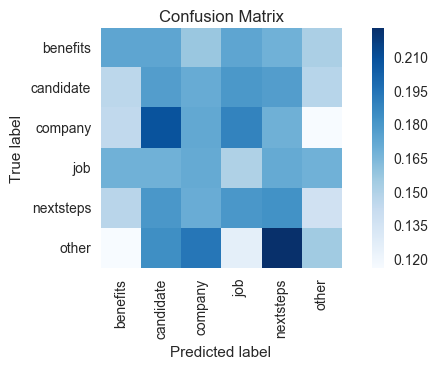

In [263]:
# Compute the confusion matrix
cm = sklearn.metrics.confusion_matrix(
    Y_categorical_test, uniform_Y_pred)
# plot it using my own plot function
plot_confusion_matrix(cm, Y_categorical_labels, 
                      normalized=True)

## Methods

__Approach 1:__ Vector Space Models

- N-Gram Models
- Distributed Representations

__Approach 2:__ Sequential Models

- Recurrent Neural Networks

## Approach 1: Vector Space Models

- Represent a sentence as a vector

- Sentences are mapped into a common vector space 

-  Similar sentences are close to each other

- Usual approach:
    1. Build Vector Space Model (often called Feature Extraction)
    2. Apply a classifier to predict class label

### Classifiers for Vector Space Models

- Generalized Linear Models: ``sklearn.linear_model``

- Bayesian Classifiers: ``sklearn.naive_bayes``

- Tree Based Methods: ``sklearn.tree``

- Ensemble Methods: ``sklearn.ensemble``

- Instance-based Methods: ``sklearn.neighbors``

- Kernel Methods: ``sklearn.svm``

- Neural Networks: __keras__ (high-level interface on top of TensorFlow or Theano)

### A Classic Vector Space Model: N-Grams

- Based on word occurencies
- N in N-Gram is the word-group size
- E.g. Unigram (n=1) is a histogram of word counts
- Many variations such as removing "stop words" or down weighing terms by how often they occur in the whole dataset (IDF)
- Bag-of-words: word order (mostly) is disregarded

Train a model and tune it's hyper-parameters

In [264]:
# parameters chosen from previous evaluations
tuned_parameters = [{'vect__analyzer': ['word'],
 'vect__max_features': [100],
 'vect__ngram_range': [(1, 1)],
 'vect__stop_words': [None],
 'vect__use_idf': [True]}]

In [265]:
# Make a pipeline of data processing steps
pipeline_log_reg = sklearn.pipeline.Pipeline(
    [('vect', sklearn.feature_extraction.text.TfidfVectorizer()),
     ('clf',  sklearn.linear_model.LogisticRegression())])

# Define a grid search over the parameters
classifier_ngrams = sklearn.grid_search.GridSearchCV(
    pipeline_log_reg, tuned_parameters, cv=5, 
    scoring=sklearn.metrics.make_scorer(MCC), n_jobs=4)

# Perform the grid search to find the best paramters
classifier_ngrams.fit(X_train, Y_categorical_train);

Test the model:

In [266]:
# test the performance of the model
predictions_ngrams = classifier_ngrams.predict(X_test)
predictions_ngrams_onehot = lb.transform(predictions_ngrams)

# calculate Matthews Correlation Coefficient
MCC(Y_onehot_test, predictions_ngrams_onehot)

0.60986230355385773

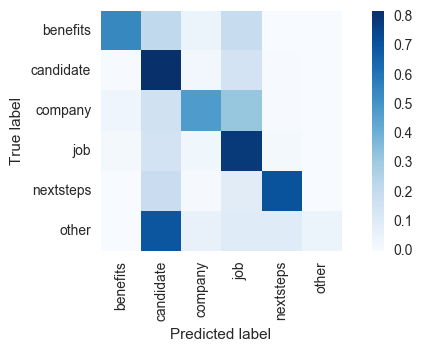

In [267]:
# Compute the confusion matrix
cm = sklearn.metrics.confusion_matrix(Y_categorical_test, predictions_ngrams)
# plot it using my own plot function
plot_confusion_matrix(cm, Y_categorical_labels, title="", normalized=True)

Lets's challenge the model with our own input:

In [288]:
# Make up a sentence from a job ad
our_sentence = ("Let's ")

prediction = classifier.predict([our_sentence])
le.inverse_transform(prediction)[0]

'candidate'

### A Modern Vector Space Model: Distributed Representations

- Learn a word representation by trying to predict a word from the words in its context

- Recently popularized by so-called word2vec model by [Mikolov et al., 2013a]

<img src="images/cbow_vert2.pdf" width="60%"/>

Vectors shown to encode linguistic structure:

<img src="images/word2vec_cities.pdf" width="80%"/>

__From words to sentences:__
- Compositional approach: Combine word vectors, e.g. average (“Bag-Of-Means”) [Mitchell and Lapata, 2010]
- Paragraph Vectors
    - Distributed Memory Model: While predicting the word from context add a “paragraph token”
    - Distributed Bag-Of-Words Model: Sample words from the paragraph and predict them given the paragraph token

- Using the __gensim__ package for natural language processing (NLP) algorithms we can create such a model easily. 
- Here a pretrained model is loaded (trained with a billion words from Google News)

In [150]:
model_word2vec = gensim.models.Word2Vec.load_word2vec_format(
    "~/thesis/data/word2vec/GoogleNews-vectors-negative300.bin", 
    binary=True)

The "Bag-of-Means" model can be created by simply averaging the vectors for each sentence

In [270]:
def build_bagofmeans(X):
    means = []
    for sentence in X:
        words = sentence.split()
        word_vectors = []
        for word in words: 
            try:
                word_vectors.append(model_word2vec[word])
            except:
                pass # word not in vocabulary
        if word_vectors != []:
            mean = np.matrix(np.mean(word_vectors, axis=0))
        else:
            mean = np.zeros((1,300))
        means.append(mean)
    return np.vstack(means)

Now we can transform the data into vector representations

In [271]:
X_bagofmeans_train = build_bagofmeans(X_train)
X_bagofmeans_test  = build_bagofmeans(X_test)
X_bagofmeans  = build_bagofmeans(data_X)

We can train a model similarly as above:

In [272]:
# Define a logistic regression classifier and train it
classifier_bagofmeans = sklearn.linear_model.LogisticRegression()
classifier_bagofmeans.fit(X_bagofmeans_train, Y_categorical_train);

In [273]:
# Make predictions with the trained classifier 
predictions_bagofmeans = classifier_bagofmeans.predict(X_bagofmeans_test)
predictions_bagofmeans = lb.transform(predictions_bagofmeans)

# Measure the MCC score
MCC(Y_onehot_test, predictions_bagofmeans)

0.70193376004857766

## Sequential Models

- Text seen as signal of characters (or words) in time
- In language strong dependencies of the time points

### Neural Networks


<img src="images/neural_net.jpg" width="40%">

- Universal function approximators

- Biologically motivated by neurons

A neural network in Keras:

In [274]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()

model.add(Dense(output_dim=64, input_dim=300))
model.add(Activation("relu"))
model.add(Dense(output_dim=6))
model.add(Activation("softmax"))

We need to compile it:

In [275]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Now we can train it:

In [278]:
model.fit(X_bagofmeans_train, Y_onehot_train, nb_epoch=10, batch_size=32);

Epoch 1/10
6963/6963 [==============================] - 0s - loss: 1.3046 - acc: 0.5235     
Epoch 2/10
6963/6963 [==============================] - 0s - loss: 1.2639 - acc: 0.5446     
Epoch 3/10
6963/6963 [==============================] - 0s - loss: 1.2243 - acc: 0.5709     
Epoch 4/10
6963/6963 [==============================] - 0s - loss: 1.1863 - acc: 0.5913     
Epoch 5/10
6963/6963 [==============================] - 0s - loss: 1.1504 - acc: 0.6094     
Epoch 6/10
6963/6963 [==============================] - 0s - loss: 1.1172 - acc: 0.6256     
Epoch 7/10
6963/6963 [==============================] - 0s - loss: 1.0865 - acc: 0.6361     
Epoch 8/10
6963/6963 [==============================] - 0s - loss: 1.0587 - acc: 0.6470     
Epoch 9/10
6963/6963 [==============================] - 0s - loss: 1.0334 - acc: 0.6527     
Epoch 10/10
6963/6963 [==============================] - 0s - loss: 1.0105 - acc: 0.6569     


Now we can predict and measure score:

In [279]:
predictions_nn = model.predict_classes(X_bagofmeans_test, batch_size=32)
MCC(Y_categorical_test, predictions_nn)

1888/2985 [=================>............] - ETA: 0s

0.53132311299119261

### Recurrent Neural Networks

<img src="images/RNN-unrolled.png" width="70%">

<small>Image stolen from http://colah.github.io/posts/2015-08-Understanding-LSTMs<small>

- Neural Networks with "loops"

- Unrolling: Network “copied across the time dimension”

- Network was built to model text on character-level

### Models used:
- Simple LSTM: Single recurrent layer
- Stacked LSTM: Three recurrent layers, first two return sequences
- Multi-task LSTM: Generative model. Objective: Given a sequence of characters, predict next character and the label at this character

## Results

- Distributed Representations slightly outperform N-Grams (but the improvement is marginal):
    - Best MCC score for Distributed Representations: __0.716__ (Bag-of-Means and Neural Network)
    - Best MCC score for N-Grams: __0.713__ (using an SVM classifier)



- Sequential Model (Recurrent Neural Network) almost on par: __0.707__ MCC score

- For Distributed Reprensentations and Recurrent Neural Networks the dataset is tiny: Better performance can be expected with more data

### Conclusion 1: Trend towards Representation Learning Methods

- Less assumptions about the problem domain

- Generally shown to perform better 

- Free us from having to do "feature engineering"

### Conclusion 2: Python is awesome for Machine Learning research

- Data manipulation is easy, wide array of tools available

- Large and active community using python for research

- It's a serious programming language

## Kiitos! 

Now it's Q&A time



### Python packages used: 

- requests
- beautifulsoup
- pandas
- scikit-learn
- keras
- seaborn
- matplotlib
- probably more ...

### My thesis 

- Tex files and pdf: https://github.com/cle-ment/ma-thesis-tex
- The final experiments on AWS (a little messy): https://github.com/cle-ment/ma-thesis-experiments
- The crowdsource tagging tool built for collecting the first dataset: https://github.com/cle-ment/ma-thesis-crowdsource-text-tagger